In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py
import math
import innvestigate
import keras
import xarray as xr
import tensorflow as tf
import cartopy

df_olr = xr.load_dataset('df_olr.nc')
df_wg = xr.load_dataset('df_era5.nc')
pph_data = pd.read_csv('pph_loc_mean.csv').rename(
    columns={'Unnamed: 0': 'date'}).set_index('date')

label_list = list(np.datetime_as_string(df_olr.time.values))
for i, val in enumerate(label_list):
    label_list[i] = val.split('T')[0]

HORIZON = 7  # PPH from 7 days afterwords
WINDOW = 30  # assumes sliding in days
test_labels = label_list[label_list.index(
    '2016-11-01'):label_list.index('2019-05-31')]

# creates a expanding window from given label -- WORKS!


def get_window_expanding(label="", label_list=label_list):
    try:
        # take the season
        # season_index = label_list.index(label)

        # grab all the days previous to one that you have
        window = [0]*(len(label_list)-7)
        for i in range(len(window)):
            window[i] = label_list[len(label_list)-i-8]
        # return window and label
        return window, label

    # printing error when value is not in seasons list
    except:
        return "Label not found in list"


# creates a sliding window from given label -- WORKS!
def get_window_sliding(label="", window_num=WINDOW):
    try:
        # ensure not grabbing from diff season
        day_index = label_list.index(label)
        m = int(label.split('-')[1])
        d = int(label.split('-')[2])

        # for values that are almost outside the season, use and expanding window
        if (m == 11) or (m == 12 and d < 7):
            y = label.split('-')[0]
            stopper = y+'-11-01'  # end of the season
            stop_index = label_list.index(stopper)

            # creates a new list to grab data from
            label_list_copy = label_list.copy()[stop_index:day_index+1]

            return (get_window_expanding(label=label, label_list=label_list_copy))

        else:
            window = [0]*(window_num)

            for i in range(len(window)):
                # TODO: 7 days between or pph_day - last_day = 7
                window[i] = label_list[day_index-i-7]
            return window, label

    except:
        return "Label not found in list"


# returns wind and geopotential dataframe for prev 30 days (minus 7d), olr dataframe for prev 30 days(minus 7d),
# and pph data for the given date
def get_data(date):
    dates = get_window_sliding(date)
    past_dates = dates[0]
    target_data = pph_data.loc[date]
    # print(len(past_dates))
    if len(past_dates) == 0:
        return [], [], target_data
    slicer = slice(past_dates[-1], past_dates[0])

    return df_wg.sel(time=slicer), df_olr.sel(time=slicer), target_data


# building testing datasets
test_era5_data = np.zeros((635, 30, 51, 241, 2))
for i, val in enumerate(test_labels):
    try:
        day_index = label_list.index(val)
        m = int(val.split('-')[1])
        d = int(val.split('-')[2])
        if len(get_data(val)[0].u250.values) == 0:
            test_era5_data[i, :, :, :, 0] = np.full((30, 51, 241), 0)

        elif (m == 11) or (m == 12 and d < 7):
            r = np.zeros((30, 51, 241))
            n = get_data(val)[0].u250.values
            r[0:len(n), :, :] = n
            r[len(n):, :, :] = np.full(((30-len(n)), 51, 241), 0)
            test_era5_data[i, :, :, :, 0] = r
        else:
            d = get_data(val)[0].u250.values
            test_era5_data[i, :, :, :, 0] = d
        # print(val)
    except Exception as e:
        test_era5_data[i, :, :, :, 0] = np.full((30, 51, 241), 0)

for i, val in enumerate(test_labels):
    try:
        day_index = label_list.index(val)
        m = int(val.split('-')[1])
        d = int(val.split('-')[2])
        if len(get_data(val)[0].z500.values) == 0:
            test_era5_data[i, :, :, :, 1] = np.full((30, 51, 241), 0)

        elif (m == 11) or (m == 12 and d < 7):
            r = np.zeros((30, 51, 241))
            n = get_data(val)[0].z500.values
            r[0:len(n), :, :] = n
            r[len(n):, :, :] = np.full(((30-len(n)), 51, 241), 0)
            test_era5_data[i, :, :, :, 1] = r
        else:
            d = get_data(val)[0].z500.values
            test_era5_data[i, :, :, :, 1] = d
        # print(val)
    except Exception as e:
        test_era5_data[i, :, :, :, 1] = np.full((30, 51, 241), 0)

test_olr_data = np.zeros((635, 30, 13, 144, 1))
for i, val in enumerate(test_labels):
    try:
        day_index = label_list.index(val)
        m = int(val.split('-')[1])
        d = int(val.split('-')[2])
        if len(get_data(val)[1].olr.values) == 0:
            test_olr_data[i, :, :, :, 0] = np.full((30, 13, 144), 0)

        elif (m == 11) or (m == 12 and d < 7):
            r = np.zeros((30,  13, 144))
            n = get_data(val)[1].olr.values
            r[0:len(n), :, :] = n
            r[len(n):, :, :] = np.full(((30-len(n)), 13, 144), 0)
            test_olr_data[i, :, :, :, 0] = r
        else:
            d = get_data(val)[1].olr.values
            test_olr_data[i, :, :, :, 0] = d
        # print(val)
    except Exception as e:
        test_olr_data[i, :, :, :, 0] = np.full((30, 13, 144), 0)

test_pph_data = np.zeros((635, 9))
for i, val in enumerate(test_labels):
    test_pph_data[i, :] = np.array(list(get_data(val)[2].to_dict().values()))

# loading in models
model_relu = keras.models.load_model('my_model_relu_10_2.h5')
# model095 = keras.models.load_model('my_model_095.h5')


tf.compat.v1.disable_eager_execution()
analyzer = innvestigate.create_analyzer(
    name='lrp.sequential_preset_a', model=model_relu, reverse_verbose=True)
print('here pre')


LRPSEQA_heatmap625 = analyzer.analyze(
    [tf.constant(np.reshape(test_era5_data[625, :, :, :], (1, 30, 51, 241, 2))), tf.constant(np.reshape(test_olr_data[625, :, :, :], (1, 30, 13, 144, 1)))])



here pre
Tensor("dense_2_2/Relu:0", shape=(None, 9), dtype=float32)
Reverse model: <keras.engine.functional.Functional object at 0x7f8629054130>
[NID: 22] Reverse layer-node <innvestigate.layers.MaxNeuronSelection object at 0x7f862903f4f0>
[NID: 21] Reverse layer-node <keras.layers.core.dense.Dense object at 0x7f865e6f5e20>
[NID: 20] Reverse layer-node <keras.layers.core.dense.Dense object at 0x7f865e6f5c70>
[NID: 19] Reverse layer-node <keras.layers.regularization.dropout.Dropout object at 0x7f865e6f5880>
[NID: 18] Reverse layer-node <keras.layers.core.dense.Dense object at 0x7f865e6f5520>
[NID: 17] Reverse layer-node <keras.layers.regularization.dropout.Dropout object at 0x7f865e72fd60>
[NID: 16] Reverse layer-node <keras.layers.merging.concatenate.Concatenate object at 0x7f865e6f5310>
[NID: 15] Reverse layer-node <keras.layers.reshaping.flatten.Flatten object at 0x7f865e72ff70>
[NID: 14] Reverse layer-node <keras.layers.reshaping.flatten.Flatten object at 0x7f865e6f5100>
[NID: 13] R

/opt/anaconda3/envs/reu_proj/lib/python3.9/site-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [223]:
slicer = slice("2016-11-01", "2019-05-31")

print(list(df_olr.sel(time=slicer).time)[625])
print(list(df_olr.sel(time=slicer).time)[132])
print(list(df_olr.sel(time=slicer).time)[624])
print(list(df_olr.sel(time=slicer).time)[593])
print(list(df_olr.sel(time=slicer).time)[351])


<xarray.DataArray 'time' ()>
array('2019-05-21T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2019-05-21
<xarray.DataArray 'time' ()>
array('2017-03-13T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2017-03-13
<xarray.DataArray 'time' ()>
array('2019-05-20T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2019-05-20
<xarray.DataArray 'time' ()>
array('2019-04-19T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2019-04-19
<xarray.DataArray 'time' ()>
array('2018-03-20T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2018-03-20


In [18]:
# np.shape(LRPSEQA_heatmap625[0])
np.shape(LRPSEQA_heatmap625[1])
mean_graph625 = np.mean(np.mean(np.mean(a=LRPSEQA_heatmap625[1], axis=0), axis=0), axis=2)

df_olr_xai_625 = xr.Dataset(
    {"olr": (("x", "y"), mean_graph625)},
    coords={
        "x": np.array(df_olr.lat),
        "y": np.array(df_olr.lon),
    },
)
df_olr_xai_625


<xarray.Dataset>
Dimensions:  (x: 13, y: 144)
Coordinates:
  * x        (x) float32 15.0 12.5 10.0 7.5 5.0 ... -5.0 -7.5 -10.0 -12.5 -15.0
  * y        (y) float32 0.0 2.5 5.0 7.5 10.0 ... 347.5 350.0 352.5 355.0 357.5
Data variables:
    olr      (x, y) float32 1.422e-06 2.492e-06 ... -2.411e-06 -7.285e-07

In [19]:
# np.shape(LRPSEQA_heatmap625[0])
np.shape(LRPSEQA_heatmap625[0])
mean_graph625_era = np.mean(np.mean(a=LRPSEQA_heatmap625[0], axis=0), axis=0)


df_era5_xai_625 = xr.Dataset(
    {"u250": (("x", "y"), mean_graph625_era[:,:,0]),
     "z500": (("x", "y"), mean_graph625_era[:,:,1]),
     },
    coords={
        "x": np.array(df_wg.lat),
        "y": np.array(df_wg.lon),
    },
)
df_era5_xai_625

<xarray.Dataset>
Dimensions:  (x: 51, y: 241)
Coordinates:
  * x        (x) float64 90.0 88.5 87.0 85.5 84.0 ... 21.0 19.5 18.0 16.5 15.0
  * y        (y) float64 -180.0 -178.5 -177.0 -175.5 ... 175.5 177.0 178.5 180.0
Data variables:
    u250     (x, y) float32 -3.282e-09 -5.4e-09 ... 2.11e-06 1.007e-06
    z500     (x, y) float32 -2.206e-06 -3.746e-06 ... 2.829e-07 1.112e-07

In [20]:
def olr_my_grapher(selec,mult=1e6 ,start=-5,end=5,spc=0.25):
    selection=selec
    fig=plt.figure(figsize=(9,6))
    plt.style.use('default')
    ax = plt.axes(projection = cartopy.crs.PlateCarree())
    ax.add_feature(cartopy.feature.LAND,facecolor='grey')
    ax.add_feature(cartopy.feature.OCEAN, alpha = 0.5)
    ax.add_feature(cartopy.feature.COASTLINE,linewidth=0.5)
    ax.add_feature(cartopy.feature.LAKES, alpha = 0.5)
    ax.add_feature(cartopy.feature.STATES,linewidth=0.5)


    plt.contourf(selection.y.values, selection.x.values, selection.olr.values*mult, levels=[0,2], colors=['#FFFFFF'],
                 transform=cartopy.crs.PlateCarree(), alpha=0.)
    
    try:
        c = plt.contourf(selection.y.values, selection.x.values, selection.olr.values*mult, cmap='hot_r',
                 levels=np.arange(start,end,spc),
                 transform=cartopy.crs.PlateCarree())
        c2 = plt.contour(selection.y.values, selection.x.values, selection.olr.values*mult, colors = ["#000000"],
                 transform=cartopy.crs.PlateCarree(), linewidths=0.5)

        cbar=plt.colorbar(c)
        cbar.set_label('olr',rotation=270,labelpad=20)

        plt.ylabel('thing')
        plt.title("OLR Plot: ")

    except Exception as e: 
        print(e)
        plt.annotate("No Reports", xy=(0.5, 0.5), xycoords="figure fraction",
                      va="center", ha="center", color='white',
                      bbox=dict(boxstyle="round", fc="k"))

    

In [30]:
def g_plotter(selec,mult=1e6 , low=-5, high=5, sep=0.5):
    selection=selec
    fig=plt.figure(figsize=(9,6))
    plt.style.use('default')
    ax = plt.axes(projection = cartopy.crs.PlateCarree())
    ax.add_feature(cartopy.feature.LAND,facecolor='grey')
    ax.add_feature(cartopy.feature.OCEAN, alpha = 0.5)
    ax.add_feature(cartopy.feature.COASTLINE,linewidth=0.5)
    ax.add_feature(cartopy.feature.LAKES, alpha = 0.5)
    ax.add_feature(cartopy.feature.STATES,linewidth=0.5) 

    
    plt.contourf(selection.y.values, selection.x.values, (selection.z500.values)*mult, levels=[0,2], colors=['#FFFFFF'],
                 transform=cartopy.crs.PlateCarree(), alpha=0.)

    try:
        c = plt.contourf(selection.y.values, selection.x.values, (selection.z500.values)*mult, cmap='bwr',
                         rotation=270,labelpad=20,
                         levels=np.arange(low,high,sep),
                         transform=cartopy.crs.PlateCarree())
        cbar=plt.colorbar(c)
        cbar.set_label('z500',rotation=270,labelpad=20)

        plt.ylabel('thing')
        plt.title("Z500 Plot")
    except:
        plt.annotate("No Reports", xy=(0.5, 0.5), xycoords="figure fraction",
                      va="center", ha="center", color='white',
                      bbox=dict(boxstyle="round", fc="k"))

In [31]:
def w_plotter(selec,mult=1e6 , low=-5, high=5, sep=0.5):
    selection=selec
    fig=plt.figure(figsize=(9,6))
    plt.style.use('default')
    ax = plt.axes(projection = cartopy.crs.PlateCarree())
    ax.add_feature(cartopy.feature.LAND,facecolor='grey')
    ax.add_feature(cartopy.feature.OCEAN, alpha = 0.5)
    ax.add_feature(cartopy.feature.COASTLINE,linewidth=0.5)
    ax.add_feature(cartopy.feature.LAKES, alpha = 0.5)
    ax.add_feature(cartopy.feature.STATES,linewidth=0.5) 

    
    plt.contourf(selection.y.values, selection.x.values, (selection.u250.values)*mult, levels=[0,2], colors=['#FFFFFF'],
                 transform=cartopy.crs.PlateCarree(), alpha=0.)

    try:
        c = plt.contourf(selection.y.values, selection.x.values, (selection.u250.values)*mult, cmap='bwr',
                         rotation=270,labelpad=20,
                         levels=np.arange(low,high,sep),
                         transform=cartopy.crs.PlateCarree())
        cbar=plt.colorbar(c)
        cbar.set_label('u250',rotation=270,labelpad=20)

        plt.ylabel('thing')
        plt.title("U250 Plot")
    except:
        plt.annotate("No Reports", xy=(0.5, 0.5), xycoords="figure fraction",
                      va="center", ha="center", color='white',
                      bbox=dict(boxstyle="round", fc="k"))

In [156]:
df_wg

<xarray.Dataset>
Dimensions:  (time: 8268, y: 51, x: 241)
Coordinates:
  * time     (time) datetime64[ns] 1979-11-01 1979-11-02 ... 2019-05-31
    lon      (x) float64 -180.0 -178.5 -177.0 -175.5 ... 175.5 177.0 178.5 180.0
    lat      (y) float64 90.0 88.5 87.0 85.5 84.0 ... 21.0 19.5 18.0 16.5 15.0
Dimensions without coordinates: y, x
Data variables:
    u250     (time, y, x) float64 0.001868 0.001868 0.001868 ... 0.6402 0.6402
    z500     (time, y, x) float64 0.6994 0.6994 0.6994 ... 0.1216 0.1254 0.1254
Attributes:
    description:  Wind speed and Geopotential Anomoly Data

# Graphs with the largest predicted values then the largest actual values for each severe storm category (tor, wind, hail)

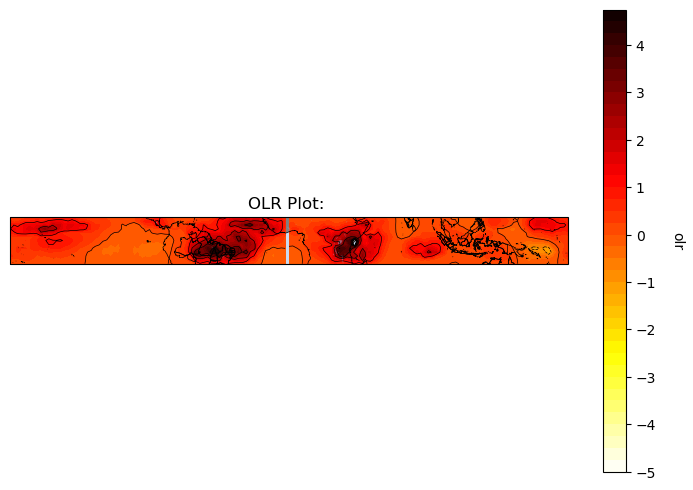

In [24]:
olr_my_grapher(df_olr_xai_625, mult=1e4)

The following kwargs were not used by contour: 'rotation', 'labelpad'


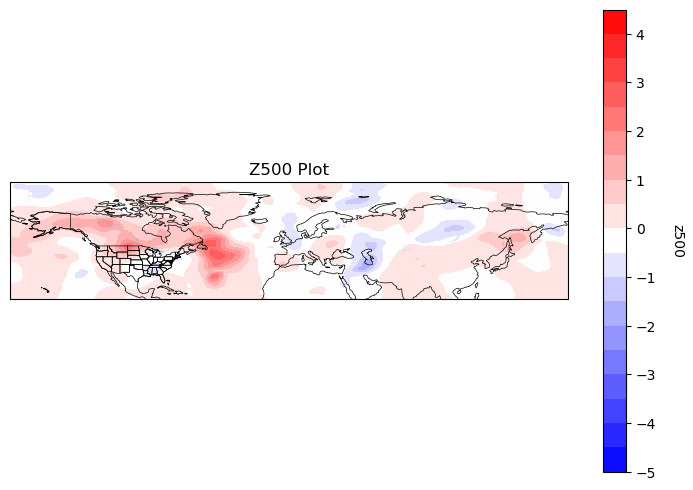

In [188]:
g_plotter(df_era5_xai_625, mult=1e5)

The following kwargs were not used by contour: 'rotation', 'labelpad'


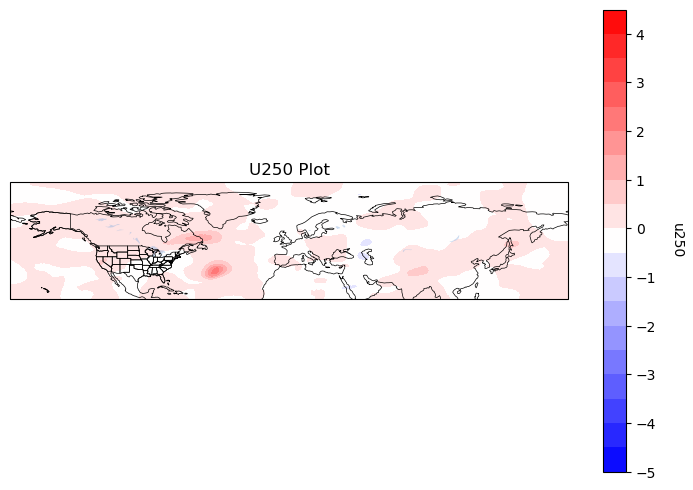

In [204]:
w_plotter(df_era5_xai_625, mult=1e4)

In [138]:
tf.compat.v1.disable_eager_execution()
analyzer = innvestigate.create_analyzer(
    name='lrp.sequential_preset_a', model=model_relu, reverse_verbose=True)
print('here pre')


LRPSEQA_heatmap132 = analyzer.analyze(
    [tf.constant(np.reshape(test_era5_data[132, :, :, :], (1, 30, 51, 241, 2))), tf.constant(np.reshape(test_olr_data[132, :, :, :], (1, 30, 13, 144, 1)))])

# np.shape(LRPSEQA_heatmap625[0])
np.shape(LRPSEQA_heatmap132[1])
mean_graph132 = np.mean(np.mean(np.mean(a=LRPSEQA_heatmap132[1], axis=0), axis=0), axis=2)

df_olr_xai_132 = xr.Dataset(
    {"olr": (("x", "y"), mean_graph132)},
    coords={
        "x": np.array(df_olr.lat),
        "y": np.array(df_olr.lon),
    },
)
df_olr_xai_132

<xarray.Dataset>
Dimensions:  (x: 13, y: 144)
Coordinates:
  * x        (x) float32 15.0 12.5 10.0 7.5 5.0 ... -5.0 -7.5 -10.0 -12.5 -15.0
  * y        (y) float32 0.0 2.5 5.0 7.5 10.0 ... 347.5 350.0 352.5 355.0 357.5
Data variables:
    olr      (x, y) float32 9.816e-07 1.646e-06 ... -5.149e-07 -2.165e-07

In [180]:
np.shape(LRPSEQA_heatmap132[0])
mean_graph132_era = np.mean(np.mean(a=LRPSEQA_heatmap132[0], axis=0), axis=0)


df_era5_xai_132 = xr.Dataset(
    {"u250": (("x", "y"), mean_graph132_era[:,:,0]),
     "z500": (("x", "y"), mean_graph132_era[:,:,1]),
     },
    coords={
        "x": np.array(df_wg.lat),
        "y": np.array(df_wg.lon),
    },
)
df_era5_xai_132

<xarray.Dataset>
Dimensions:  (x: 51, y: 241)
Coordinates:
  * x        (x) float64 90.0 88.5 87.0 85.5 84.0 ... 21.0 19.5 18.0 16.5 15.0
  * y        (y) float64 -180.0 -178.5 -177.0 -175.5 ... 175.5 177.0 178.5 180.0
Data variables:
    u250     (x, y) float32 -1.246e-09 -1.934e-09 ... 3.864e-07 1.877e-07
    z500     (x, y) float32 -4.761e-07 -8.69e-07 ... 1.187e-07 4.676e-08

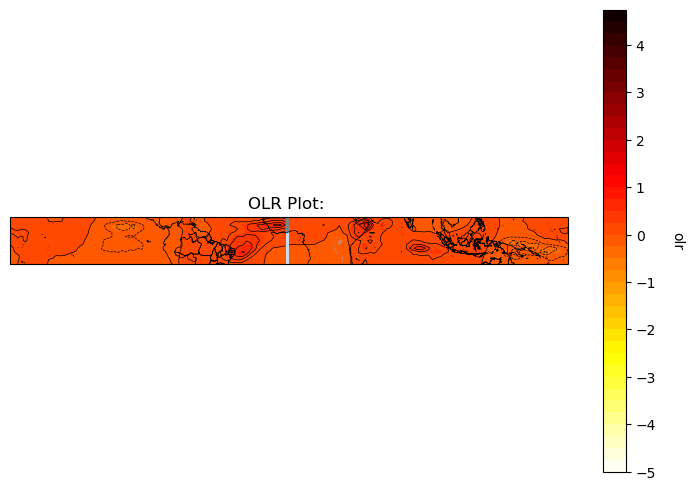

In [151]:
olr_my_grapher(df_olr_xai_132, mult=1e4) 

The following kwargs were not used by contour: 'rotation', 'labelpad'


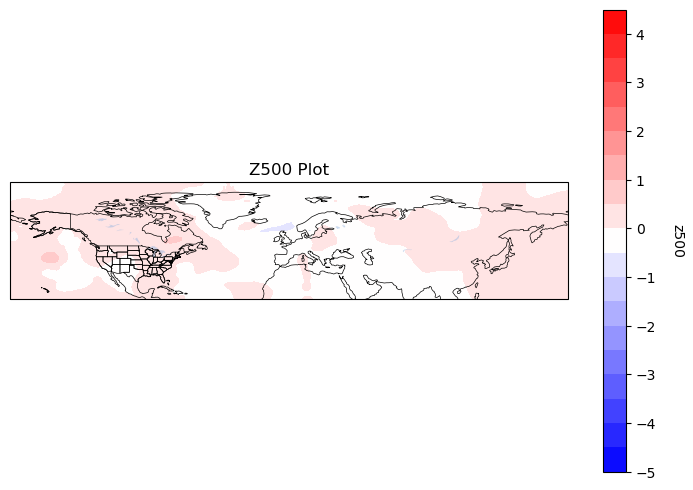

In [189]:
g_plotter(df_era5_xai_132, mult=1e5)

The following kwargs were not used by contour: 'rotation', 'labelpad'


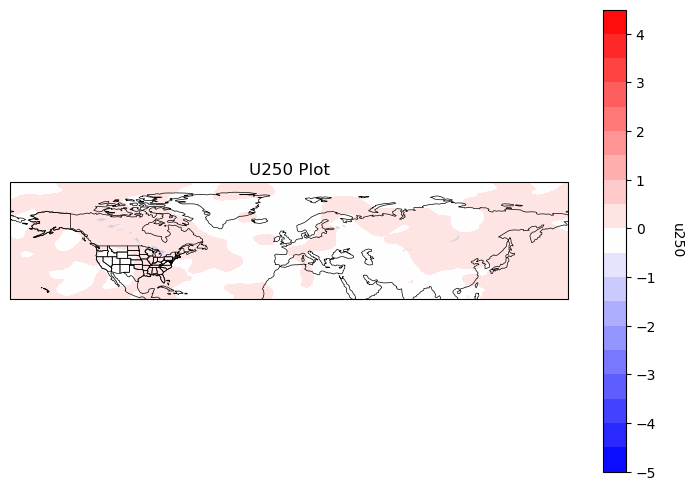

In [205]:
w_plotter(df_era5_xai_132, mult=1e4)

In [146]:
tf.compat.v1.disable_eager_execution()
analyzer = innvestigate.create_analyzer(
    name='lrp.sequential_preset_a', model=model_relu, reverse_verbose=True)
print('here pre')


LRPSEQA_heatmap624 = analyzer.analyze(
    [tf.constant(np.reshape(test_era5_data[624, :, :, :], (1, 30, 51, 241, 2))), tf.constant(np.reshape(test_olr_data[624, :, :, :], (1, 30, 13, 144, 1)))])

# np.shape(LRPSEQA_heatmap625[0])
np.shape(LRPSEQA_heatmap624[1])
mean_graph624 = np.mean(np.mean(np.mean(a=LRPSEQA_heatmap624[1], axis=0), axis=0), axis=2)

df_olr_xai_624 = xr.Dataset(
    {"olr": (("x", "y"), mean_graph624)},
    coords={
        "x": np.array(df_olr.lat),
        "y": np.array(df_olr.lon),
    },
)
df_olr_xai_624

here pre
Tensor("dense_2_1/Relu:0", shape=(None, 9), dtype=float32)
Reverse model: <keras.engine.functional.Functional object at 0x7fce34c1b8b0>
[NID: 22] Reverse layer-node <innvestigate.layers.MaxNeuronSelection object at 0x7fce375a88e0>
[NID: 21] Reverse layer-node <keras.layers.core.dense.Dense object at 0x7fce31180d30>
[NID: 20] Reverse layer-node <keras.layers.core.dense.Dense object at 0x7fce31180b80>
[NID: 19] Reverse layer-node <keras.layers.regularization.dropout.Dropout object at 0x7fce31180790>
[NID: 18] Reverse layer-node <keras.layers.core.dense.Dense object at 0x7fce31180430>
[NID: 17] Reverse layer-node <keras.layers.regularization.dropout.Dropout object at 0x7fce3117fc70>
[NID: 16] Reverse layer-node <keras.layers.merging.concatenate.Concatenate object at 0x7fce31180220>
[NID: 15] Reverse layer-node <keras.layers.reshaping.flatten.Flatten object at 0x7fce3117fe80>
[NID: 14] Reverse layer-node <keras.layers.reshaping.flatten.Flatten object at 0x7fce3117feb0>
[NID: 13] R

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


<xarray.Dataset>
Dimensions:  (x: 13, y: 144)
Coordinates:
  * x        (x) float32 15.0 12.5 10.0 7.5 5.0 ... -5.0 -7.5 -10.0 -12.5 -15.0
  * y        (y) float32 0.0 2.5 5.0 7.5 10.0 ... 347.5 350.0 352.5 355.0 357.5
Data variables:
    olr      (x, y) float32 2.18e-06 3.498e-06 ... -2.881e-06 -9.684e-07

In [190]:
np.shape(LRPSEQA_heatmap624[0])
mean_graph624_era = np.mean(np.mean(a=LRPSEQA_heatmap624[0], axis=0), axis=0)


df_era5_xai_624 = xr.Dataset(
    {"u250": (("x", "y"), mean_graph624_era[:,:,0]),
     "z500": (("x", "y"), mean_graph624_era[:,:,1]),
     },
    coords={
        "x": np.array(df_wg.lat),
        "y": np.array(df_wg.lon),
    },
)
df_era5_xai_624

<xarray.Dataset>
Dimensions:  (x: 51, y: 241)
Coordinates:
  * x        (x) float64 90.0 88.5 87.0 85.5 84.0 ... 21.0 19.5 18.0 16.5 15.0
  * y        (y) float64 -180.0 -178.5 -177.0 -175.5 ... 175.5 177.0 178.5 180.0
Data variables:
    u250     (x, y) float32 -2.52e-09 -4.141e-09 ... 2.072e-06 9.906e-07
    z500     (x, y) float32 -1.381e-06 -2.326e-06 ... 2.499e-07 1.001e-07

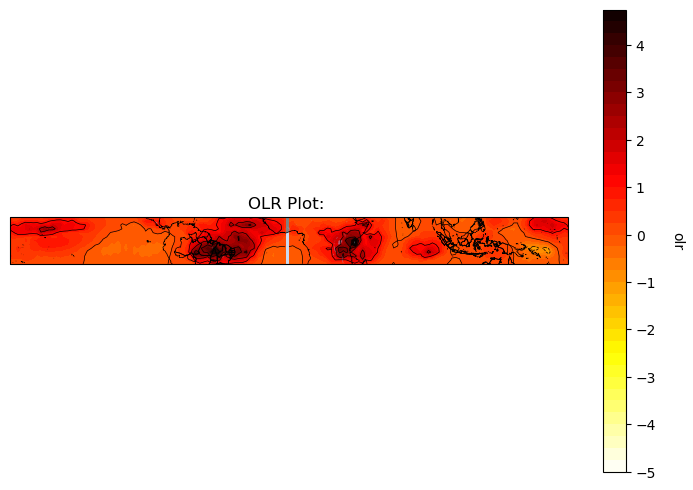

In [148]:
olr_my_grapher(df_olr_xai_624, mult=1e4) 

The following kwargs were not used by contour: 'rotation', 'labelpad'


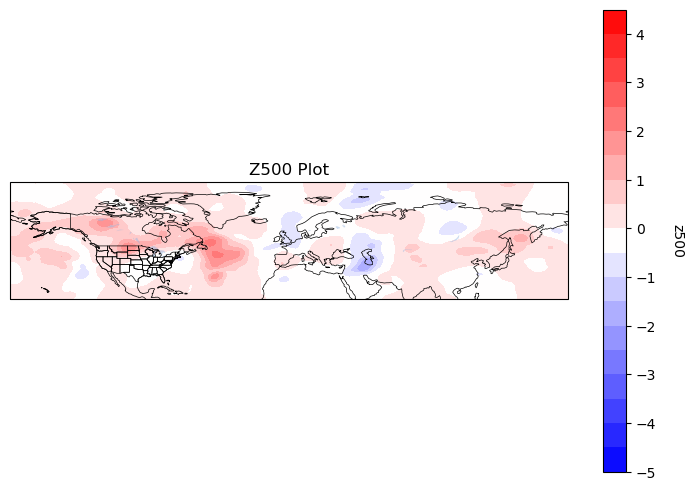

In [191]:
g_plotter(df_era5_xai_624, mult=1e5)

The following kwargs were not used by contour: 'rotation', 'labelpad'


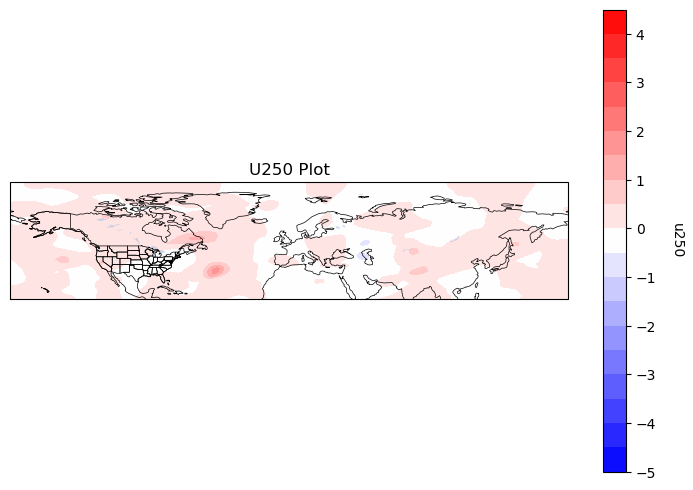

In [206]:
w_plotter(df_era5_xai_624, mult=1e4)

In [14]:
tf.compat.v1.disable_eager_execution()
analyzer = innvestigate.create_analyzer(
    name='lrp.sequential_preset_a', model=model_relu, reverse_verbose=True)
print('here pre')


LRPSEQA_heatmap593 = analyzer.analyze(
    [tf.constant(np.reshape(test_era5_data[593, :, :, :], (1, 30, 51, 241, 2))), tf.constant(np.reshape(test_olr_data[593, :, :, :], (1, 30, 13, 144, 1)))])

# np.shape(LRPSEQA_heatmap625[0])
np.shape(LRPSEQA_heatmap593[1])
mean_graph593 = np.mean(np.mean(np.mean(a=LRPSEQA_heatmap593[1], axis=0), axis=0), axis=2)

df_olr_xai_593 = xr.Dataset(
    {"olr": (("x", "y"), mean_graph593)},
    coords={
        "x": np.array(df_olr.lat),
        "y": np.array(df_olr.lon),
    },
)
df_olr_xai_593

here pre
Tensor("dense_2/Relu:0", shape=(None, 9), dtype=float32)
Reverse model: <keras.engine.functional.Functional object at 0x7f8608b302e0>
[NID: 22] Reverse layer-node <innvestigate.layers.MaxNeuronSelection object at 0x7f86086a70d0>
[NID: 21] Reverse layer-node <keras.layers.core.dense.Dense object at 0x7f8659897ee0>
[NID: 20] Reverse layer-node <keras.layers.core.dense.Dense object at 0x7f8659897d30>
[NID: 19] Reverse layer-node <keras.layers.regularization.dropout.Dropout object at 0x7f8659897910>
[NID: 18] Reverse layer-node <keras.layers.core.dense.Dense object at 0x7f8659897760>
[NID: 17] Reverse layer-node <keras.layers.regularization.dropout.Dropout object at 0x7f8659898fd0>
[NID: 16] Reverse layer-node <keras.layers.merging.concatenate.Concatenate object at 0x7f86598973a0>
[NID: 15] Reverse layer-node <keras.layers.reshaping.flatten.Flatten object at 0x7f8659898df0>
[NID: 14] Reverse layer-node <keras.layers.reshaping.flatten.Flatten object at 0x7f8659897190>
[NID: 13] Rev

/opt/anaconda3/envs/reu_proj/lib/python3.9/site-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


<xarray.Dataset>
Dimensions:  (x: 13, y: 144)
Coordinates:
  * x        (x) float32 15.0 12.5 10.0 7.5 5.0 ... -5.0 -7.5 -10.0 -12.5 -15.0
  * y        (y) float32 0.0 2.5 5.0 7.5 10.0 ... 347.5 350.0 352.5 355.0 357.5
Data variables:
    olr      (x, y) float32 5.903e-06 9.751e-06 ... -4.714e-06 -1.882e-06

In [57]:
np.shape(LRPSEQA_heatmap593[0])
mean_graph593_era = np.mean(np.mean(a=LRPSEQA_heatmap593[0], axis=0), axis=0)


df_era5_xai_593 = xr.Dataset(
    {"u250": (("x", "y"), mean_graph593_era[:,:,0]),
     "z500": (("x", "y"), mean_graph593_era[:,:,1]),
     },
    coords={
        "x": np.array(df_wg.lat),
        "y": np.array(df_wg.lon),
    },
)
df_era5_xai_593

<xarray.Dataset>
Dimensions:  (x: 51, y: 241)
Coordinates:
  * x        (x) float64 90.0 88.5 87.0 85.5 84.0 ... 21.0 19.5 18.0 16.5 15.0
  * y        (y) float64 -180.0 -178.5 -177.0 -175.5 ... 175.5 177.0 178.5 180.0
Data variables:
    u250     (x, y) float32 -3.716e-09 -6.212e-09 ... 4.514e-06 2.214e-06
    z500     (x, y) float32 -1.562e-06 -2.878e-06 ... 9.734e-07 4.003e-07

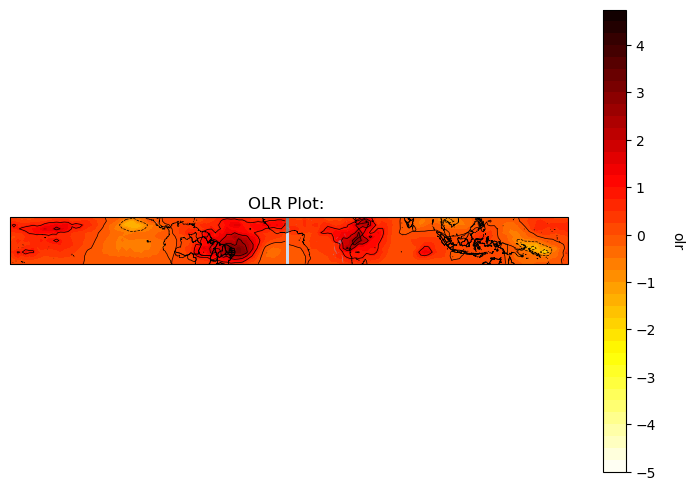

In [58]:
olr_my_grapher(df_olr_xai_593, mult=1e4) 

/opt/anaconda3/envs/reu_proj/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1662: UserWarning: The following kwargs were not used by contour: 'rotation', 'labelpad'
  result = super().contourf(*args, **kwargs)


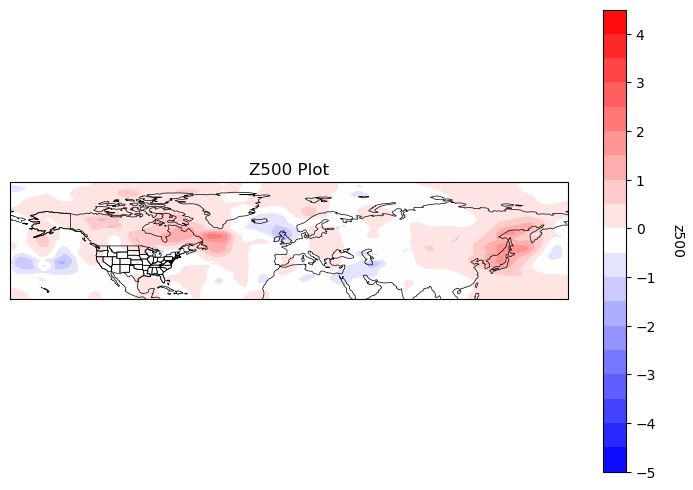

In [59]:
g_plotter(df_era5_xai_593, mult=1e5)

The following kwargs were not used by contour: 'rotation', 'labelpad'


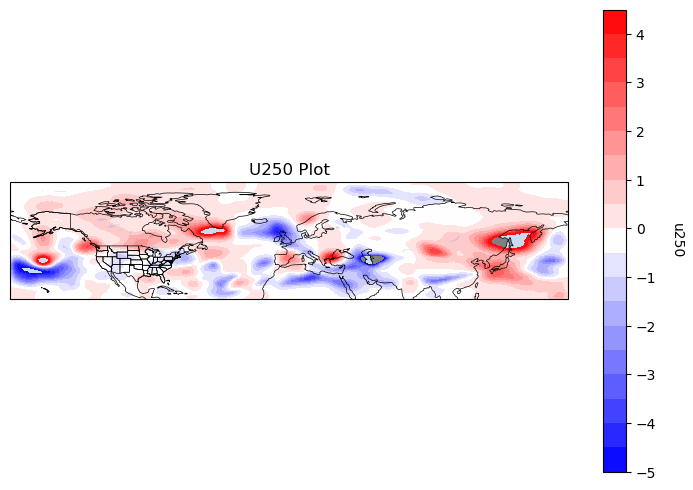

In [212]:
w_plotter(df_era5_xai_593, mult=1e5)

In [152]:

tf.compat.v1.disable_eager_execution()
analyzer = innvestigate.create_analyzer(
    name='lrp.sequential_preset_a', model=model_relu, reverse_verbose=True)
print('here pre')


LRPSEQA_heatmap351 = analyzer.analyze(
    [tf.constant(np.reshape(test_era5_data[351, :, :, :], (1, 30, 51, 241, 2))), tf.constant(np.reshape(test_olr_data[351, :, :, :], (1, 30, 13, 144, 1)))])

# np.shape(LRPSEQA_heatmap625[0])
np.shape(LRPSEQA_heatmap351[1])
mean_graph351 = np.mean(np.mean(np.mean(a=LRPSEQA_heatmap351[1], axis=0), axis=0), axis=2)

df_olr_xai_351 = xr.Dataset(
    {"olr": (("x", "y"), mean_graph351)},
    coords={
        "x": np.array(df_olr.lat),
        "y": np.array(df_olr.lon),
    },
)
df_olr_xai_351

here pre
Tensor("dense_2_1/Relu:0", shape=(None, 9), dtype=float32)
Reverse model: <keras.engine.functional.Functional object at 0x7fcd81e65460>
[NID: 22] Reverse layer-node <innvestigate.layers.MaxNeuronSelection object at 0x7fcd814fc0a0>
[NID: 21] Reverse layer-node <keras.layers.core.dense.Dense object at 0x7fce31180d30>
[NID: 20] Reverse layer-node <keras.layers.core.dense.Dense object at 0x7fce31180b80>
[NID: 19] Reverse layer-node <keras.layers.regularization.dropout.Dropout object at 0x7fce31180790>
[NID: 18] Reverse layer-node <keras.layers.core.dense.Dense object at 0x7fce31180430>
[NID: 17] Reverse layer-node <keras.layers.regularization.dropout.Dropout object at 0x7fce3117fc70>
[NID: 16] Reverse layer-node <keras.layers.merging.concatenate.Concatenate object at 0x7fce31180220>
[NID: 15] Reverse layer-node <keras.layers.reshaping.flatten.Flatten object at 0x7fce3117fe80>
[NID: 14] Reverse layer-node <keras.layers.reshaping.flatten.Flatten object at 0x7fce3117feb0>
[NID: 13] R

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


<xarray.Dataset>
Dimensions:  (x: 13, y: 144)
Coordinates:
  * x        (x) float32 15.0 12.5 10.0 7.5 5.0 ... -5.0 -7.5 -10.0 -12.5 -15.0
  * y        (y) float32 0.0 2.5 5.0 7.5 10.0 ... 347.5 350.0 352.5 355.0 357.5
Data variables:
    olr      (x, y) float32 1.336e-06 2.371e-06 ... -1.057e-06 -4.637e-07

In [194]:
np.shape(LRPSEQA_heatmap351[0])
mean_graph351_era = np.mean(np.mean(a=LRPSEQA_heatmap351[0], axis=0), axis=0)


df_era5_xai_351= xr.Dataset(
    {"u250": (("x", "y"), mean_graph351_era[:,:,0]),
     "z500": (("x", "y"), mean_graph351_era[:,:,1]),
     },
    coords={
        "x": np.array(df_wg.lat),
        "y": np.array(df_wg.lon),
    },
)
df_era5_xai_351

<xarray.Dataset>
Dimensions:  (x: 51, y: 241)
Coordinates:
  * x        (x) float64 90.0 88.5 87.0 85.5 84.0 ... 21.0 19.5 18.0 16.5 15.0
  * y        (y) float64 -180.0 -178.5 -177.0 -175.5 ... 175.5 177.0 178.5 180.0
Data variables:
    u250     (x, y) float32 -3.757e-10 -5.743e-10 ... 2.331e-06 1.132e-06
    z500     (x, y) float32 -6.114e-07 -1.024e-06 ... 4.598e-07 1.714e-07

In [195]:
np.shape(LRPSEQA_heatmap351[0])
mean_graph351_era = np.mean(np.mean(a=LRPSEQA_heatmap351[0], axis=0), axis=0)


df_era5_xai_351 = xr.Dataset(
    {"u250": (("x", "y"), mean_graph351_era[:,:,0]),
     "z500": (("x", "y"), mean_graph351_era[:,:,1]),
     },
    coords={
        "x": np.array(df_wg.lat),
        "y": np.array(df_wg.lon),
    },
)
df_era5_xai_351

<xarray.Dataset>
Dimensions:  (x: 51, y: 241)
Coordinates:
  * x        (x) float64 90.0 88.5 87.0 85.5 84.0 ... 21.0 19.5 18.0 16.5 15.0
  * y        (y) float64 -180.0 -178.5 -177.0 -175.5 ... 175.5 177.0 178.5 180.0
Data variables:
    u250     (x, y) float32 -3.757e-10 -5.743e-10 ... 2.331e-06 1.132e-06
    z500     (x, y) float32 -6.114e-07 -1.024e-06 ... 4.598e-07 1.714e-07

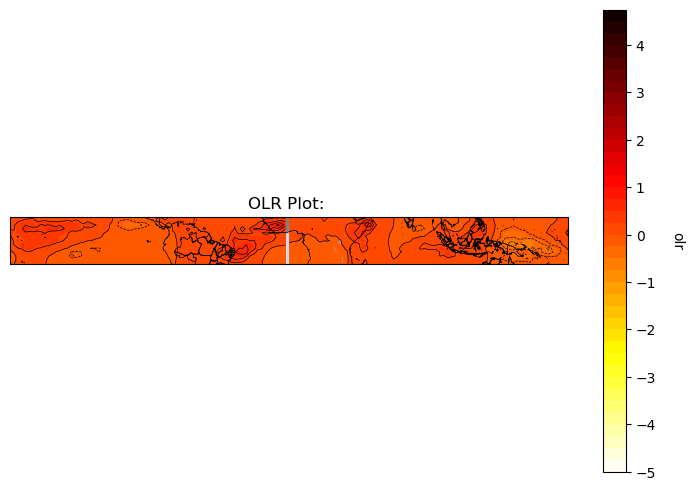

In [155]:
olr_my_grapher(df_olr_xai_351, mult=1e4)

The following kwargs were not used by contour: 'rotation', 'labelpad'


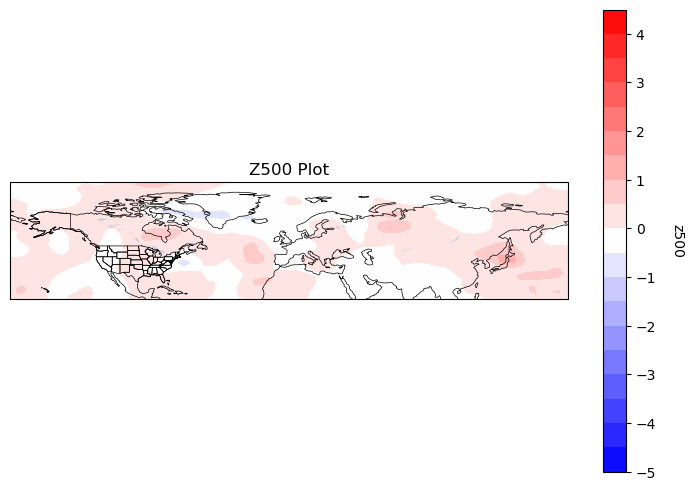

In [196]:
g_plotter(df_era5_xai_351, mult=1e5)

The following kwargs were not used by contour: 'rotation', 'labelpad'


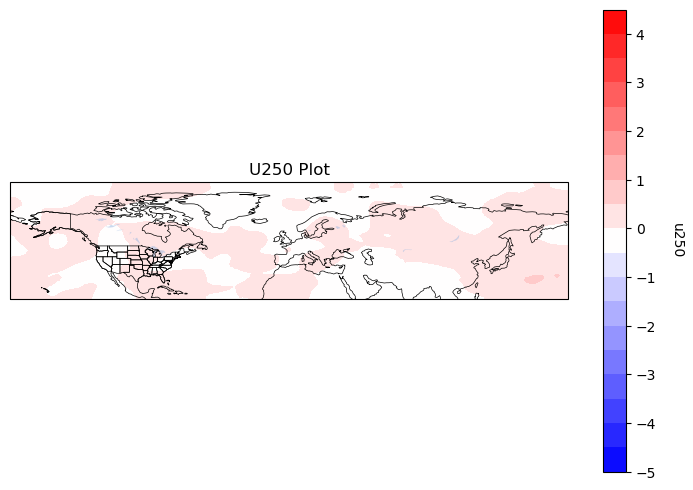

In [211]:
w_plotter(df_era5_xai_351, mult=1e4)

# Best Losses Graphs (Loss != 0)

In [2]:
#628, 178, 592, 412

In [26]:
tf.compat.v1.disable_eager_execution()

analyzer = innvestigate.create_analyzer(
    name='lrp.sequential_preset_a', model=model_relu, reverse_verbose=True)
print('here pre')

LRPSEQA_heatmap628 = analyzer.analyze(
    [tf.constant(np.reshape(test_era5_data[628, :, :, :], (1, 30, 51, 241, 2))), tf.constant(np.reshape(test_olr_data[628, :, :, :], (1, 30, 13, 144, 1)))])

# np.shape(LRPSEQA_heatmap625[0])
np.shape(LRPSEQA_heatmap628[1])
mean_graph628 = np.mean(np.mean(np.mean(a=LRPSEQA_heatmap628[1], axis=0), axis=0), axis=2)

df_olr_xai_628 = xr.Dataset(
    {"olr": (("x", "y"), mean_graph628)},
    coords={
        "x": np.array(df_olr.lat),
        "y": np.array(df_olr.lon),
    },
)
np.shape(LRPSEQA_heatmap628[0])
mean_graph628_era = np.mean(np.mean(a=LRPSEQA_heatmap628[0], axis=0), axis=0)


df_era5_xai_628 = xr.Dataset(
    {"u250": (("x", "y"), mean_graph628_era[:,:,0]),
     "z500": (("x", "y"), mean_graph628_era[:,:,1]),
     },
    coords={
        "x": np.array(df_wg.lat),
        "y": np.array(df_wg.lon),
    },
)


here pre
Tensor("dense_2_2/Relu:0", shape=(None, 9), dtype=float32)
Reverse model: <keras.engine.functional.Functional object at 0x7f862badb280>
[NID: 22] Reverse layer-node <innvestigate.layers.MaxNeuronSelection object at 0x7f862badb490>
[NID: 21] Reverse layer-node <keras.layers.core.dense.Dense object at 0x7f865e6f5e20>
[NID: 20] Reverse layer-node <keras.layers.core.dense.Dense object at 0x7f865e6f5c70>
[NID: 19] Reverse layer-node <keras.layers.regularization.dropout.Dropout object at 0x7f865e6f5880>
[NID: 18] Reverse layer-node <keras.layers.core.dense.Dense object at 0x7f865e6f5520>
[NID: 17] Reverse layer-node <keras.layers.regularization.dropout.Dropout object at 0x7f865e72fd60>
[NID: 16] Reverse layer-node <keras.layers.merging.concatenate.Concatenate object at 0x7f865e6f5310>
[NID: 15] Reverse layer-node <keras.layers.reshaping.flatten.Flatten object at 0x7f865e72ff70>
[NID: 14] Reverse layer-node <keras.layers.reshaping.flatten.Flatten object at 0x7f865e6f5100>
[NID: 13] R

/opt/anaconda3/envs/reu_proj/lib/python3.9/site-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


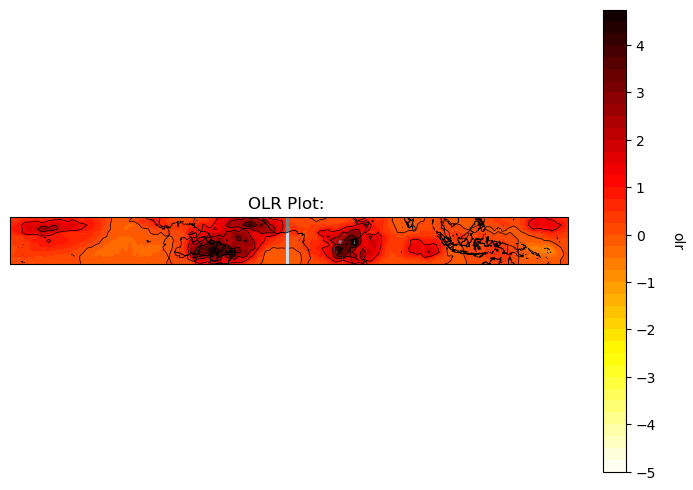

In [28]:
olr_my_grapher(df_olr_xai_628, mult=1e4)

/opt/anaconda3/envs/reu_proj/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1662: UserWarning: The following kwargs were not used by contour: 'rotation', 'labelpad'
  result = super().contourf(*args, **kwargs)


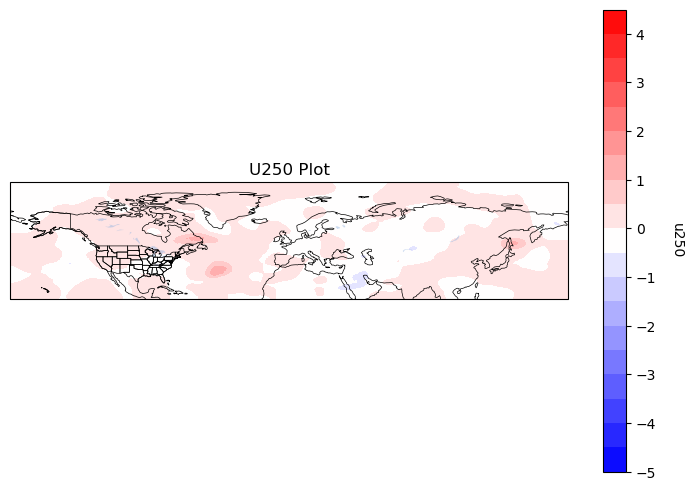

In [34]:
w_plotter(df_era5_xai_628, mult=1e4)

/opt/anaconda3/envs/reu_proj/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1662: UserWarning: The following kwargs were not used by contour: 'rotation', 'labelpad'
  result = super().contourf(*args, **kwargs)


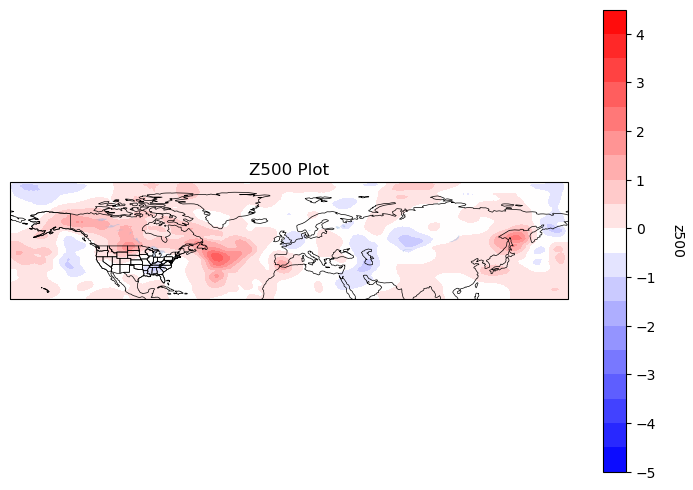

In [36]:
g_plotter(df_era5_xai_628, mult=1e5)

In [38]:
tf.compat.v1.disable_eager_execution()

analyzer = innvestigate.create_analyzer(
    name='lrp.sequential_preset_a', model=model_relu, reverse_verbose=True)
print('here pre')

LRPSEQA_heatmap178 = analyzer.analyze(
    [tf.constant(np.reshape(test_era5_data[178, :, :, :], (1, 30, 51, 241, 2))), tf.constant(np.reshape(test_olr_data[178, :, :, :], (1, 30, 13, 144, 1)))])

# np.shape(LRPSEQA_heatmap625[0])
np.shape(LRPSEQA_heatmap178[1])
mean_graph178 = np.mean(np.mean(np.mean(a=LRPSEQA_heatmap178[1], axis=0), axis=0), axis=2)

df_olr_xai_178 = xr.Dataset(
    {"olr": (("x", "y"), mean_graph178)},
    coords={
        "x": np.array(df_olr.lat),
        "y": np.array(df_olr.lon),
    },
)
np.shape(LRPSEQA_heatmap178[0])
mean_graph178_era = np.mean(np.mean(a=LRPSEQA_heatmap178[0], axis=0), axis=0)


df_era5_xai_178 = xr.Dataset(
    {"u250": (("x", "y"), mean_graph178_era[:,:,0]),
     "z500": (("x", "y"), mean_graph178_era[:,:,1]),
     },
    coords={
        "x": np.array(df_wg.lat),
        "y": np.array(df_wg.lon),
    },
)


here pre
Tensor("dense_2_2/Relu:0", shape=(None, 9), dtype=float32)
Reverse model: <keras.engine.functional.Functional object at 0x7f862c514940>
[NID: 22] Reverse layer-node <innvestigate.layers.MaxNeuronSelection object at 0x7f862f96ca60>
[NID: 21] Reverse layer-node <keras.layers.core.dense.Dense object at 0x7f865e6f5e20>
[NID: 20] Reverse layer-node <keras.layers.core.dense.Dense object at 0x7f865e6f5c70>
[NID: 19] Reverse layer-node <keras.layers.regularization.dropout.Dropout object at 0x7f865e6f5880>
[NID: 18] Reverse layer-node <keras.layers.core.dense.Dense object at 0x7f865e6f5520>
[NID: 17] Reverse layer-node <keras.layers.regularization.dropout.Dropout object at 0x7f865e72fd60>
[NID: 16] Reverse layer-node <keras.layers.merging.concatenate.Concatenate object at 0x7f865e6f5310>
[NID: 15] Reverse layer-node <keras.layers.reshaping.flatten.Flatten object at 0x7f865e72ff70>
[NID: 14] Reverse layer-node <keras.layers.reshaping.flatten.Flatten object at 0x7f865e6f5100>
[NID: 13] R

/opt/anaconda3/envs/reu_proj/lib/python3.9/site-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


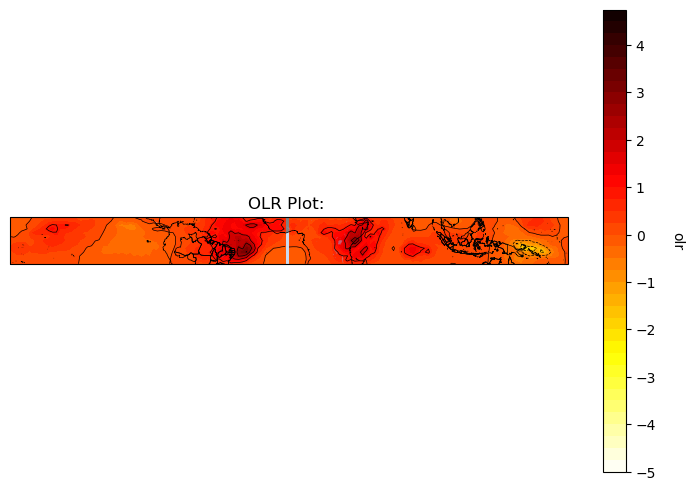

In [39]:
olr_my_grapher(df_olr_xai_178, mult=1e4)

/opt/anaconda3/envs/reu_proj/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1662: UserWarning: The following kwargs were not used by contour: 'rotation', 'labelpad'
  result = super().contourf(*args, **kwargs)


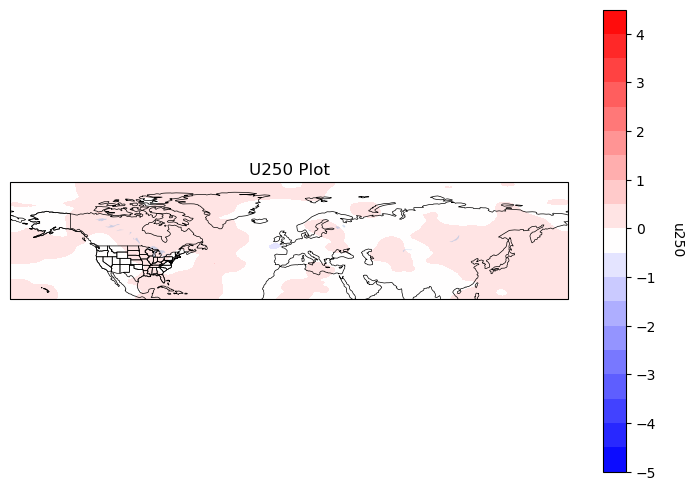

In [42]:
w_plotter(df_era5_xai_178, mult=1e4)

/opt/anaconda3/envs/reu_proj/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1662: UserWarning: The following kwargs were not used by contour: 'rotation', 'labelpad'
  result = super().contourf(*args, **kwargs)


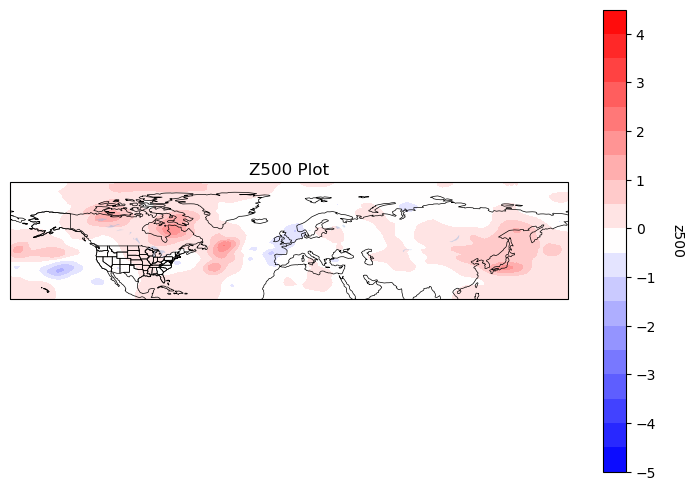

In [46]:
g_plotter(df_era5_xai_178, mult=1e5)

In [47]:
tf.compat.v1.disable_eager_execution()

analyzer = innvestigate.create_analyzer(
    name='lrp.sequential_preset_a', model=model_relu, reverse_verbose=True)
print('here pre')

LRPSEQA_heatmap592 = analyzer.analyze(
    [tf.constant(np.reshape(test_era5_data[592, :, :, :], (1, 30, 51, 241, 2))), tf.constant(np.reshape(test_olr_data[592, :, :, :], (1, 30, 13, 144, 1)))])

# np.shape(LRPSEQA_heatmap625[0])
np.shape(LRPSEQA_heatmap592[1])
mean_graph592 = np.mean(np.mean(np.mean(a=LRPSEQA_heatmap592[1], axis=0), axis=0), axis=2)

df_olr_xai_592 = xr.Dataset(
    {"olr": (("x", "y"), mean_graph592)},
    coords={
        "x": np.array(df_olr.lat),
        "y": np.array(df_olr.lon),
    },
)
np.shape(LRPSEQA_heatmap592[0])
mean_graph592_era = np.mean(np.mean(a=LRPSEQA_heatmap592[0], axis=0), axis=0)


df_era5_xai_592 = xr.Dataset(
    {"u250": (("x", "y"), mean_graph592_era[:,:,0]),
     "z500": (("x", "y"), mean_graph592_era[:,:,1]),
     },
    coords={
        "x": np.array(df_wg.lat),
        "y": np.array(df_wg.lon),
    },
)


here pre
Tensor("dense_2_2/Relu:0", shape=(None, 9), dtype=float32)
Reverse model: <keras.engine.functional.Functional object at 0x7f831d21b100>
[NID: 22] Reverse layer-node <innvestigate.layers.MaxNeuronSelection object at 0x7f8435668b50>
[NID: 21] Reverse layer-node <keras.layers.core.dense.Dense object at 0x7f865e6f5e20>
[NID: 20] Reverse layer-node <keras.layers.core.dense.Dense object at 0x7f865e6f5c70>
[NID: 19] Reverse layer-node <keras.layers.regularization.dropout.Dropout object at 0x7f865e6f5880>
[NID: 18] Reverse layer-node <keras.layers.core.dense.Dense object at 0x7f865e6f5520>
[NID: 17] Reverse layer-node <keras.layers.regularization.dropout.Dropout object at 0x7f865e72fd60>
[NID: 16] Reverse layer-node <keras.layers.merging.concatenate.Concatenate object at 0x7f865e6f5310>
[NID: 15] Reverse layer-node <keras.layers.reshaping.flatten.Flatten object at 0x7f865e72ff70>
[NID: 14] Reverse layer-node <keras.layers.reshaping.flatten.Flatten object at 0x7f865e6f5100>
[NID: 13] R

/opt/anaconda3/envs/reu_proj/lib/python3.9/site-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


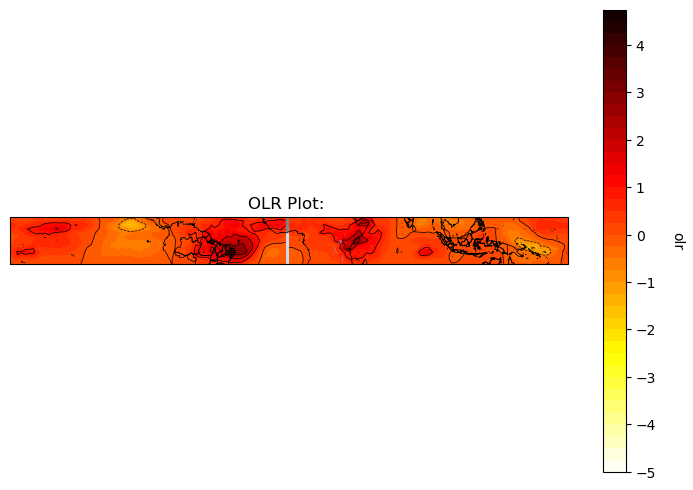

In [48]:
olr_my_grapher(df_olr_xai_592, mult=1e4)

/opt/anaconda3/envs/reu_proj/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1662: UserWarning: The following kwargs were not used by contour: 'rotation', 'labelpad'
  result = super().contourf(*args, **kwargs)


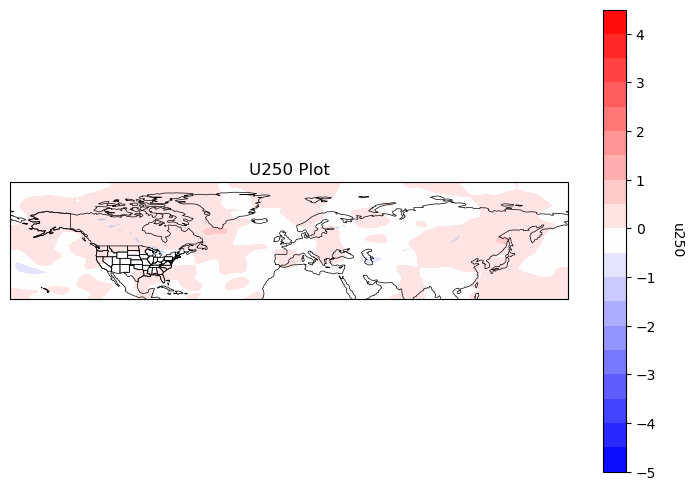

In [51]:
w_plotter(df_era5_xai_592, mult=1e4)

/opt/anaconda3/envs/reu_proj/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1662: UserWarning: The following kwargs were not used by contour: 'rotation', 'labelpad'
  result = super().contourf(*args, **kwargs)


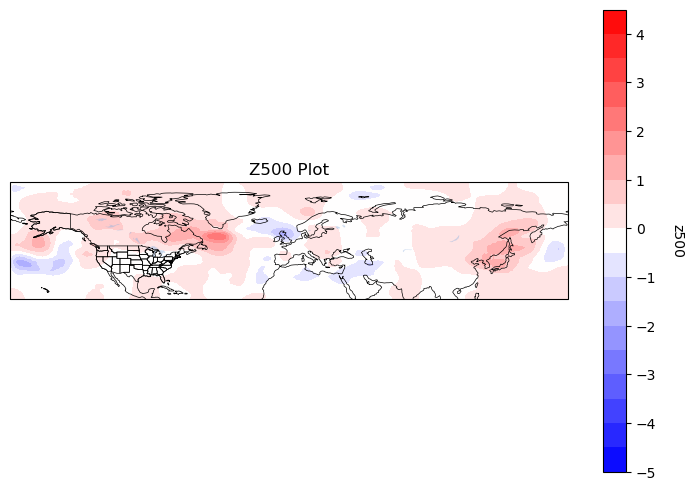

In [52]:
g_plotter(df_era5_xai_592, mult=1e5)

In [53]:
tf.compat.v1.disable_eager_execution()

analyzer = innvestigate.create_analyzer(
    name='lrp.sequential_preset_a', model=model_relu, reverse_verbose=True)
print('here pre')

LRPSEQA_heatmap412 = analyzer.analyze(
    [tf.constant(np.reshape(test_era5_data[412, :, :, :], (1, 30, 51, 241, 2))), tf.constant(np.reshape(test_olr_data[412, :, :, :], (1, 30, 13, 144, 1)))])

# np.shape(LRPSEQA_heatmap625[0])
np.shape(LRPSEQA_heatmap412[1])
mean_graph412 = np.mean(np.mean(np.mean(a=LRPSEQA_heatmap412[1], axis=0), axis=0), axis=2)

df_olr_xai_412 = xr.Dataset(
    {"olr": (("x", "y"), mean_graph412)},
    coords={
        "x": np.array(df_olr.lat),
        "y": np.array(df_olr.lon),
    },
)
np.shape(LRPSEQA_heatmap412[0])
mean_graph412_era = np.mean(np.mean(a=LRPSEQA_heatmap412[0], axis=0), axis=0)


df_era5_xai_412 = xr.Dataset(
    {"u250": (("x", "y"), mean_graph412_era[:,:,0]),
     "z500": (("x", "y"), mean_graph412_era[:,:,1]),
     },
    coords={
        "x": np.array(df_wg.lat),
        "y": np.array(df_wg.lon),
    },
)


here pre
Tensor("dense_2_2/Relu:0", shape=(None, 9), dtype=float32)
Reverse model: <keras.engine.functional.Functional object at 0x7f84356d9d90>
[NID: 22] Reverse layer-node <innvestigate.layers.MaxNeuronSelection object at 0x7f864fd02250>
[NID: 21] Reverse layer-node <keras.layers.core.dense.Dense object at 0x7f865e6f5e20>
[NID: 20] Reverse layer-node <keras.layers.core.dense.Dense object at 0x7f865e6f5c70>
[NID: 19] Reverse layer-node <keras.layers.regularization.dropout.Dropout object at 0x7f865e6f5880>
[NID: 18] Reverse layer-node <keras.layers.core.dense.Dense object at 0x7f865e6f5520>
[NID: 17] Reverse layer-node <keras.layers.regularization.dropout.Dropout object at 0x7f865e72fd60>
[NID: 16] Reverse layer-node <keras.layers.merging.concatenate.Concatenate object at 0x7f865e6f5310>
[NID: 15] Reverse layer-node <keras.layers.reshaping.flatten.Flatten object at 0x7f865e72ff70>
[NID: 14] Reverse layer-node <keras.layers.reshaping.flatten.Flatten object at 0x7f865e6f5100>
[NID: 13] R

/opt/anaconda3/envs/reu_proj/lib/python3.9/site-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


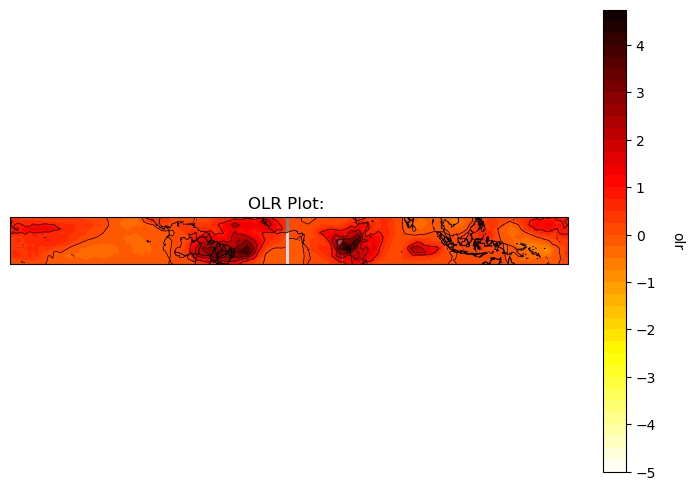

In [54]:
olr_my_grapher(df_olr_xai_412, mult=1e4)

/opt/anaconda3/envs/reu_proj/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1662: UserWarning: The following kwargs were not used by contour: 'rotation', 'labelpad'
  result = super().contourf(*args, **kwargs)


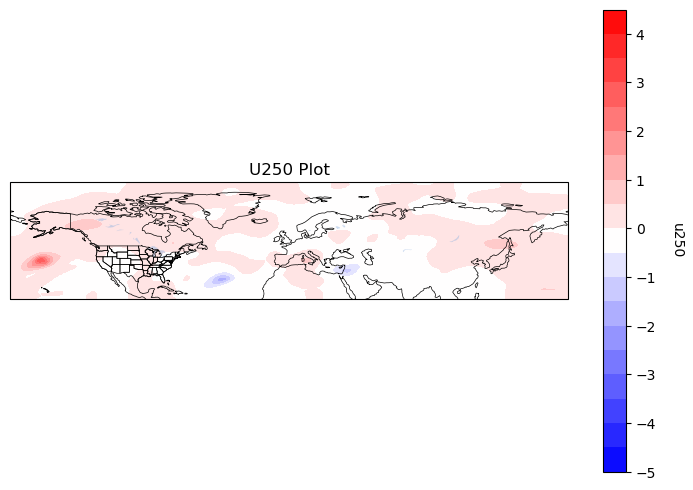

In [55]:
w_plotter(df_era5_xai_412, mult=1e4)

/opt/anaconda3/envs/reu_proj/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1662: UserWarning: The following kwargs were not used by contour: 'rotation', 'labelpad'
  result = super().contourf(*args, **kwargs)


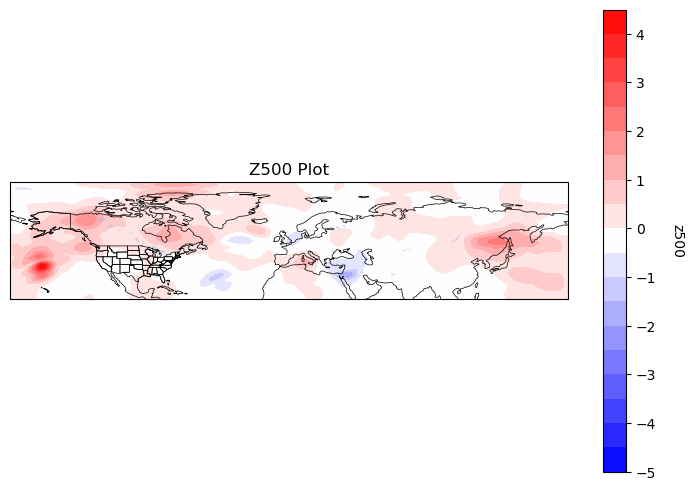

In [56]:
g_plotter(df_era5_xai_412, mult=1e5)